# Setup

In [2]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, hinge_loss

import random

import torch
import pandas as pd
from matplotlib import pyplot as plt

from torchvision import transforms
import torchvision
from torch.utils.data import DataLoader

from conex.helpers.filters import DoGFilter
from conex.helpers.transforms.misc import Conv2dFilter

from tqdm import tqdm

from PIL import Image


# Visualize

In [3]:
def load_image(path,size = None):
    img = cv2.imread(path)
    if(size):
        img = cv2.resize(img,size)
    return torch.tensor(img[:,:,0],dtype=torch.float32)

def show_image(image,normal=False):
    plt.axis("off")
    if(normal):
        plt.imshow(image,cmap='gray',vmin=0,vmax=255)
    else:
        plt.imshow(image,cmap='gray')
    plt.show()
    

def show_filters(weight):
    fig,axes = plt.subplots(1,weight.shape[0])
    fig.set_size_inches(5*weight.shape[0], 5)
    # fig.suptitle(f'plots of synaptic share weights for d = {weight.shape[0]}')
    for i in range(weight.shape[0]):
        axes[i].imshow(weight[i][0],cmap='gray')
        axes[i].axis('off')
        
        
def show_images(imgs,title,count):
    fig,axes = plt.subplots(1,count)
    fig.set_size_inches(5*count, 5)
    plt.text(x=0.5, y=0.94, s=title, fontsize=28, ha="center", transform=fig.transFigure)
    for i in range(count):
        axes[i].imshow(imgs[i][0][0],cmap='gray')
        axes[i].axis('off')


def confidence_crop_interspace(inp_width, inp_height, window_width, window_height):
    x1 = window_width//2
    x2 = (inp_width - 1) - (window_width//2)
    y1 = window_height//2 
    y2 = (inp_height - 1) - (window_height//2)

    center_x = random.randint(x1, x2)
    center_y = random.randint(y1, y2)
    center_coordinates = [center_x, center_y]
    top_left_x = center_x - (window_width//2)
    top_left_y = center_y - (window_height//2)
    top_left_coordinates = [top_left_x, top_left_y]
    coordinates = [center_coordinates, top_left_coordinates]

    return coordinates


# CONFIG

In [148]:
Input_Width = 32
Input_Height = 32
Crop_Window_Width = 18
Crop_Window_Height = 18
DoG_SIZE = 5

IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28

OUT_CHANNEL = 8
IN_CHANNEL = 1
KERNEL_WIDTH = 13
KERNEL_HEIGHT = 13

# INPUT_WIDTH = IMAGE_WIDTH - DoG_SIZE + 1
# INPUT_HEIGHT = IMAGE_HEIGHT - DoG_SIZE + 1
INPUT_WIDTH = Crop_Window_Width - DoG_SIZE + 1
INPUT_HEIGHT = Crop_Window_Height - DoG_SIZE + 1

L4_WIDTH = INPUT_WIDTH - KERNEL_WIDTH + 1
L4_HEIGHT = INPUT_HEIGHT - KERNEL_HEIGHT + 1

L23_WIDTH = L4_WIDTH//2
L23_HEIGHT = L4_HEIGHT//2

J_0 = 300
p = 0.8

# DataLoader (MNIST)

In [149]:
from torchvision.datasets import CIFAR10
CIFAR10_ROOT = "./CIFAR10"

In [150]:
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels = 1), # not necessary
    Conv2dFilter(DoGFilter(size = 5, sigma_1 = 1.01, sigma_2 = 1, zero_mean=True, one_sum=False).unsqueeze(0).unsqueeze(0)),
    # SqueezeTransform(dim = 0),
    # SimplePoisson(time_window = time_window , ratio = 2),
])


dataset = CIFAR10(root=CIFAR10_ROOT, train=True, download=False, transform=transformation)

In [7]:
dl = DataLoader(dataset=dataset, shuffle=True)
cnt = 0

base_data = torch.Tensor([])
base_targets = []
for data,target in tqdm(dl) : 
    cnt += 1
    base_data = torch.cat((base_data, data), dim = 0)
    base_targets.append(target)
    if(cnt >= 1000) : 
        break

# base_data = torch.Tensor(base_data)
# base_targets = torch.Tensor(base_targets)

  2%|▏         | 999/50000 [00:03<02:58, 275.03it/s]


In [8]:
dataset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

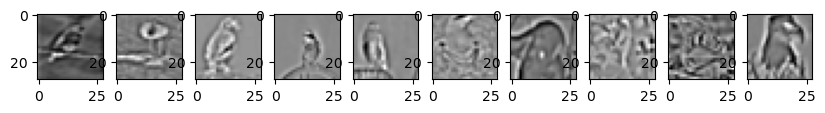

In [151]:
base_targets = torch.Tensor(base_targets)
horse_data = base_data[base_targets == 2]

rows = 1 
columns = 10
fig = plt.figure(figsize=(10, 4)) 
for i in range(1, 11) : 
    fig.add_subplot(rows, columns, i) 
    plt.imshow(horse_data[i-1].view(28, 28), cmap="gray")


In [10]:
horse_data.shape

torch.Size([107, 1, 28, 28])

In [205]:
def DataLoadCIFAR(C1 = 2, C2 = 7, sz = 80, crop_iteration = 3) :
    time_window = 100

    dataset_directory_path = "./first_step"

    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels = 1), # not necessary
        Conv2dFilter(DoGFilter(size = 5, sigma_1 = 4, sigma_2 = 1, zero_mean=True, one_sum=True).unsqueeze(0).unsqueeze(0)),
        # SqueezeTransform(dim = 0),
        # SimplePoisson(time_window = time_window , ratio = 2),
    ])


    dataset = CIFAR10(root=CIFAR10_ROOT, train=True, download=False, transform=transformation)

    dl = DataLoader(dataset=dataset, shuffle=True)
    cnt = 0

    base_data = torch.Tensor([])
    base_targets = []

    for data,target in tqdm(dl) : 
        cnt += 1
        base_data = torch.cat((base_data, data), dim = 0)
        base_targets.append(target)
        if(cnt >= 10000) : 
            break

    base_targets = torch.Tensor(base_targets)
    # base_data = torch.Tensor(base_data)
    # base_targets = torch.Tensor(base_targets)

    first_class = base_data[base_targets == C1][:sz]
    second_class = base_data[base_targets == C2][:sz]

    print(len(first_class), len(second_class))

    target = [0] * len(first_class) + [1] * len(second_class)
    target = torch.Tensor(target)

    two_class_dataset = torch.cat((first_class, second_class), dim=0)
    new_dataset_size = first_class.shape[0] + second_class.shape[0]


    new_dataset = torch.empty(0, crop_iteration, Crop_Window_Width, Crop_Window_Height)
    print("->",new_dataset.shape)
    centers = []

    
    two_class_dataset = two_class_dataset.view(new_dataset_size, 28, 28)
    print(two_class_dataset.shape)

    for i in tqdm(range(0, new_dataset_size)):
        all_cropped = torch.tensor([])
        # plt.figure(figsize=(6, 3))
        # plt.imshow(two_class_dataset[i], cmap="gray")
        # plt.show()

        # fig = plt.figure(figsize=(6, 3))
        for j in range (0, crop_iteration):
            img = two_class_dataset[i]  # 4 in range [0, 5842) ; 9 in range [5842, 11791)
            
            # img = Image.fromarray(img.numpy(), mode="L")
            # plt.imshow(img, cmap="gray")
            # plt.show()

            a = confidence_crop_interspace(Input_Width, Input_Height, Crop_Window_Width, Crop_Window_Height)
            centers.append((a[0][0], a[0][1]))
            cropped_image = torchvision.transforms.functional.crop(img, a[1][1], a[1][0], Crop_Window_Width, Crop_Window_Height)

            # fig.add_subplot(1, 3, j + 1) 
            # plt.imshow(cropped_image, cmap="gray")
            # cropped_image = Image.fromarray(cropped_image.numpy(), mode="L")
            # cropped_image = img
            # cropped_image = transformation(cropped_image)
            # cropped_image = torchvision.transforms.functional.to_tensor(cropped_image)
            cropped_image = cropped_image.view(1, Crop_Window_Width, Crop_Window_Height)
            all_cropped = torch.cat((all_cropped, cropped_image.data), dim=0)
        # plt.show()
        # break   

        all_cropped = all_cropped.view(1, crop_iteration, Crop_Window_Width, Crop_Window_Height)
        new_dataset = torch.cat((new_dataset.data, all_cropped), dim=0)

    print(new_dataset.shape)
    dl = DataLoader(new_dataset,shuffle=True)

    new_dataset = new_dataset.view(new_dataset_size, -1)
    np_data = new_dataset.numpy()
    np_target = target.numpy()

    return np_data, np_target

In [206]:
np_data, np_target = DataLoadCIFAR(1, 0, 800)

 20%|█▉        | 9999/50000 [00:39<02:36, 256.14it/s]


800 800
-> torch.Size([0, 3, 18, 18])
torch.Size([1600, 28, 28])


100%|██████████| 1600/1600 [00:01<00:00, 1577.46it/s]

torch.Size([1600, 3, 18, 18])


# ML-Based Dataset

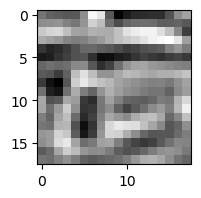

In [207]:
plt.figure(figsize=(2, 2))
plt.imshow(np_data[656].reshape(3, 18, 18)[2], cmap = "gray")

In [208]:
X_train, X_test, y_train, y_test = train_test_split(np_data, np_target, test_size=0.33, random_state=42)

# Modeling

In [209]:
from sklearn.linear_model import  SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

In [210]:
classifiers = [
    SGDClassifier(max_iter = 1000, tol = 1e-3),
    RandomForestClassifier(max_depth = 3),
    KNeighborsClassifier(n_neighbors = 3),
    SVC(gamma = 'auto'),
    LogisticRegression(),
    DecisionTreeClassifier(max_depth = 3),
    AdaBoostClassifier(algorithm="SAMME"),
    MLPClassifier(alpha=1, max_iter=1000),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    GaussianNB(),
]

In [211]:
res = []

for clf in classifiers : 
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    res.append({
        "classifier" : type(clf).__name__,
        "train_acc" : train_acc,
        "test_acc" : test_acc
    })

# Final Results

In [212]:
df = pd.DataFrame(res)
df.sort_values(by = ['test_acc'], ascending = False)

,classifier,train_acc,test_acc
1,RandomForestClassifier,0.870336,0.685606
6,AdaBoostClassifier,0.834888,0.674242
9,GaussianNB,0.652985,0.598485
5,DecisionTreeClassifier,0.657649,0.596591
0,SGDClassifier,0.855410,0.541667
7,MLPClassifier,0.900187,0.526515
4,LogisticRegression,0.755597,0.513258
2,KNeighborsClassifier,0.527985,0.481061
3,SVC,0.509328,0.481061
8,GaussianProcessClassifier,0.891791,0.481061


# Results on 60 * 2 * 3 images

In [171]:
np_data, np_target = DataLoadMNIST(4, 9, 60)
X_train, X_test, y_train, y_test = train_test_split(np_data, np_target, test_size=0.33, random_state=42)

res = []

for clf in classifiers : 
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    res.append({
        "classifier" : type(clf).__name__,
        "train_acc" : train_acc,
        "test_acc" : test_acc
    })

df = pd.DataFrame(res)
df.sort_values(by = ['test_acc'], ascending = False)

100%|██████████| 120/120 [00:00<00:00, 319.45it/s]


torch.Size([360, 17, 17])


,classifier,train_acc,test_acc
2,KNeighborsClassifier,0.900415,0.773109
6,AdaBoostClassifier,0.995851,0.739496
8,GaussianProcessClassifier,1.000000,0.739496
7,MLPClassifier,0.983402,0.705882
1,RandomForestClassifier,0.937759,0.689076
4,LogisticRegression,0.863071,0.647059
5,DecisionTreeClassifier,0.800830,0.621849
0,SGDClassifier,0.863071,0.605042
9,GaussianNB,0.738589,0.579832
3,SVC,0.510373,0.478992


# Results on 100 * 2 * 3 images

In [172]:
np_data, np_target = DataLoadMNIST(4, 9, 100)
X_train, X_test, y_train, y_test = train_test_split(np_data, np_target, test_size=0.33, random_state=42)

res = []

for clf in classifiers : 
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    res.append({
        "classifier" : type(clf).__name__,
        "train_acc" : train_acc,
        "test_acc" : test_acc
    })

df = pd.DataFrame(res)
df.sort_values(by = ['test_acc'], ascending = False)

100%|██████████| 200/200 [00:00<00:00, 331.30it/s]


torch.Size([600, 17, 17])


,classifier,train_acc,test_acc
8,GaussianProcessClassifier,1.000000,0.792929
1,RandomForestClassifier,0.905473,0.772727
2,KNeighborsClassifier,0.915423,0.767677
6,AdaBoostClassifier,0.880597,0.717172
0,SGDClassifier,0.781095,0.666667
4,LogisticRegression,0.743781,0.656566
5,DecisionTreeClassifier,0.766169,0.641414
9,GaussianNB,0.691542,0.626263
3,SVC,0.512438,0.474747
7,MLPClassifier,0.514925,0.464646


# Results on 500 * 2 * 3 images

In [173]:
np_data, np_target = DataLoadMNIST(4, 9, 500)
X_train, X_test, y_train, y_test = train_test_split(np_data, np_target, test_size=0.33, random_state=42)

res = []

for clf in classifiers : 
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    res.append({
        "classifier" : type(clf).__name__,
        "train_acc" : train_acc,
        "test_acc" : test_acc
    })

df = pd.DataFrame(res)
df.sort_values(by = ['test_acc'], ascending = False)

100%|██████████| 1000/1000 [00:04<00:00, 213.69it/s]


torch.Size([3000, 17, 17])


,classifier,train_acc,test_acc
8,GaussianProcessClassifier,1.000000,0.889899
7,MLPClassifier,0.882587,0.833333
2,KNeighborsClassifier,0.926368,0.807071
1,RandomForestClassifier,0.841791,0.803030
6,AdaBoostClassifier,0.800000,0.738384
5,DecisionTreeClassifier,0.750249,0.734343
0,SGDClassifier,0.765174,0.701010
4,LogisticRegression,0.757711,0.696970
9,GaussianNB,0.666667,0.636364
3,SVC,0.518905,0.493939
